In [1]:
# =============================================================================
# Section 0: Setup & Shared Components
# =============================================================================

# Install required libraries (uncomment if running for the first time)
!pip install -q transformers datasets scikit-learn pandas matplotlib seaborn ipywidgets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.

In [2]:
# Set random seed for reproducibility
import random
import numpy as np
import torch
from transformers import set_seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("✅ Random seed set.")



✅ Random seed set.


In [3]:
# -----------------------------------------------------------------------------
# Shared: Load and Preprocess Dataset
# -----------------------------------------------------------------------------
import pandas as pd
import re

# Load dataset
df = pd.read_csv("Dataset 11000 Reviews.tsv", sep="\t", names=["label", "text"])
df.dropna(inplace=True)

# Clean labels (only keep 'pos' and 'neg')
df['label'] = df['label'].str.strip()
df = df[df['label'].isin(['pos', 'neg'])]
df['label'] = df['label'].map({'pos': 1, 'neg': 0})

# Normalization dictionary & function
normalization_dict = {
    "boht": "bohat", "acha": "achha", "achaay": "achhay", "achaee": "achhi",
    "pyara": "piara", "mujy": "mujhe", "me": "main", "nai": "nahi", "kyun": "kyoon",
    "hain": "hain", "hy": "hai", "rha": "raha", "rhi": "rahi", "haii": "hai"
}

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Remove emojis
    text = re.sub(r'[^\w\s]', '', text)                  # Remove punctuation
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)            # Reduce repeated characters
    words = text.split()
    normalized_words = [normalization_dict.get(w, w) for w in words]
    return " ".join(normalized_words)

# Apply normalization
df['text'] = df['text'].astype(str).apply(normalize_text)
df = df[df['text'].apply(lambda x: len(x.split()) <= 150)]
df = df[df['text'].str.strip() != ""]
df.dropna(subset=['label', 'text'], inplace=True)
df['label'] = df['label'].astype(int)
df.reset_index(drop=True, inplace=True)

print("✅ Final dataset size:", len(df))
print("🔢 Label distribution:\n", df['label'].value_counts())



<ipython-input-3-fdb3b29980ca>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map({'pos': 1, 'neg': 0})


✅ Final dataset size: 10913
🔢 Label distribution:
 label
1    5677
0    5236
Name: count, dtype: int64


In [4]:
# -----------------------------------------------------------------------------
# Shared: Train/Validation Split & Dataset Class Definition
# -----------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=SEED
)

from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = [int(label) for label in labels]
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)



In [5]:
# =============================================================================
# Section A: Standalone XLM-T Implementation
# =============================================================================

# -------------------------------
# Load XLM-T Model & Tokenizer
# -------------------------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification

xlmt_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
xlmt_tokenizer = AutoTokenizer.from_pretrained(xlmt_name)
xlmt_model = AutoModelForSequenceClassification.from_pretrained(
    xlmt_name, num_labels=2, ignore_mismatched_sizes=True
)



# -------------------------------
# Tokenize & Wrap in Dataset
# -------------------------------
xlmt_train_encodings = xlmt_tokenizer(train_texts, truncation=True, padding=True, max_length=128)
xlmt_val_encodings = xlmt_tokenizer(val_texts, truncation=True, padding=True, max_length=128)

from torch.utils.data import Dataset
xlmt_train_dataset = SentimentDataset(xlmt_train_encodings, train_labels)
xlmt_val_dataset = SentimentDataset(xlmt_val_encodings, val_labels)

# -------------------------------
# Training Configuration & Trainer (XLM-T)
# -------------------------------
from transformers import TrainingArguments, Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./results_xlmt",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs_xlmt"
)

xlmt_trainer = Trainer(
    model=xlmt_model,
    args=training_args,
    train_dataset=xlmt_train_dataset,
    eval_dataset=xlmt_val_dataset,
)

print("🔵 Training standalone XLM-T model...")
xlmt_trainer.train()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🔵 Training standalone XLM-T model...


Epoch,Training Loss,Validation Loss
1,0.489700,0.425126
2,0.338600,0.396703
3,0.231600,0.621438


TrainOutput(global_step=1638, training_loss=0.33919368762527485, metrics={'train_runtime': 845.7614, 'train_samples_per_second': 30.966, 'train_steps_per_second': 1.937, 'total_flos': 1722719634969600.0, 'train_loss': 0.33919368762527485, 'epoch': 3.0})

In [6]:
# -------------------------------
# Evaluation: XLM-T Standalone
# -------------------------------
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

xlmt_preds = xlmt_trainer.predict(xlmt_val_dataset)
xlmt_pred_labels = xlmt_preds.predictions.argmax(axis=1)

acc_xlmt = accuracy_score(val_labels, xlmt_pred_labels)
f1_xlmt = f1_score(val_labels, xlmt_pred_labels)

print(f"\n✅ XLM-T Standalone Accuracy: {acc_xlmt:.4f}")
print(f"🎯 XLM-T Standalone F1 Score: {f1_xlmt:.4f}")
print("\n🧾 XLM-T Classification Report:\n", classification_report(val_labels, xlmt_pred_labels, target_names=["Negative", "Positive"]))




✅ XLM-T Standalone Accuracy: 0.8323
🎯 XLM-T Standalone F1 Score: 0.8410

🧾 XLM-T Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.82      0.82      1040
    Positive       0.84      0.85      0.84      1143

    accuracy                           0.83      2183
   macro avg       0.83      0.83      0.83      2183
weighted avg       0.83      0.83      0.83      2183



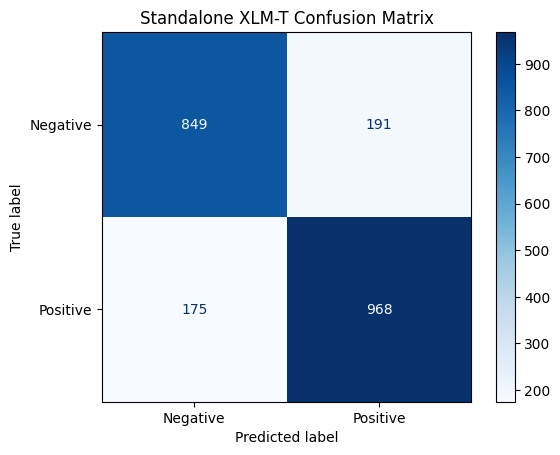

In [7]:
cm_xlmt = confusion_matrix(val_labels, xlmt_pred_labels)
disp_xlmt = ConfusionMatrixDisplay(confusion_matrix=cm_xlmt, display_labels=["Negative", "Positive"])
disp_xlmt.plot(cmap="Blues")
plt.title("Standalone XLM-T Confusion Matrix")
plt.show()



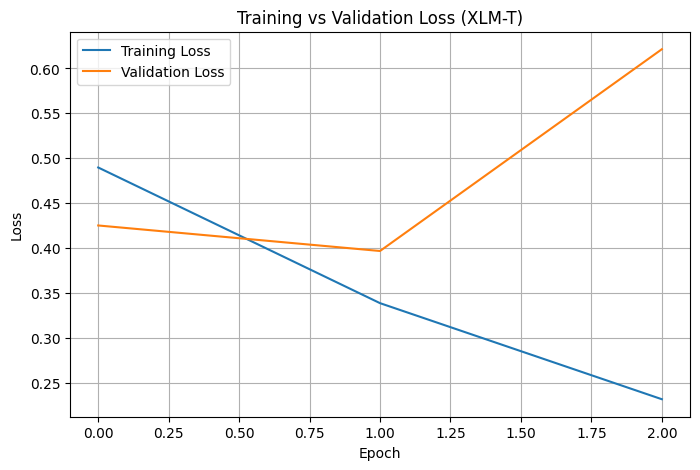

In [8]:
# Plot training vs validation loss (using XLM-T logs)
logs = xlmt_trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (XLM-T)")
plt.legend()
plt.grid()
plt.show()



In [9]:
# Save XLM-T predictions to CSV
pred_df_xlmt = pd.DataFrame({
    "text": val_texts,
    "true_label": val_labels,
    "predicted_label": xlmt_pred_labels
})
pred_df_xlmt.to_csv("xlmt_predictions.csv", index=False)
print("✅ Saved standalone XLM-T predictions to 'xlmt_predictions.csv'")



✅ Saved standalone XLM-T predictions to 'xlmt_predictions.csv'


In [10]:
# -------------------------------
# XLM-T Standalone Prediction UI
# -------------------------------
from IPython.display import display
import ipywidgets as widgets

input_box_xlmt = widgets.Text(
    value='',
    placeholder='Type your Roman Urdu review here...',
    description='XLM-T:',
    layout=widgets.Layout(width='80%')
)
output_xlmt = widgets.Output()

def predict_sentiment_xlmt(text):
    # Reuse the shared normalization function
    cleaned = normalize_text(text)
    inputs = xlmt_tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=128)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    xlmt_model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    xlmt_model.eval()
    with torch.no_grad():
        outputs = xlmt_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs).item()
        conf = probs[0][pred].item()
    label_map = {0: "Negative", 1: "Positive"}
    return label_map[pred], round(conf * 100, 2)

button_xlmt = widgets.Button(description="Predict XLM-T", button_style='success')

def on_button_click_xlmt(b):
    output_xlmt.clear_output()
    with output_xlmt:
        sentiment, confidence = predict_sentiment_xlmt(input_box_xlmt.value)
        print(f"🧠 XLM-T Predicted Sentiment: {sentiment}")
        print(f"📊 Confidence: {confidence}%")

button_xlmt.on_click(on_button_click_xlmt)
display(input_box_xlmt, button_xlmt, output_xlmt)




Text(value='', description='XLM-T:', layout=Layout(width='80%'), placeholder='Type your Roman Urdu review here…

Button(button_style='success', description='Predict XLM-T', style=ButtonStyle())

Output()

In [11]:
# =============================================================================
# Section B: Enhanced Ensemble (XLM-T + DistilBERT)
# =============================================================================

# ----- Load DistilBERT Model & Tokenizer for Ensemble -----
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# We replace XLM-R with DistilBERT (multilingual version)
distil_name = "distilbert-base-multilingual-cased"
distil_tokenizer = AutoTokenizer.from_pretrained(distil_name)
distil_model = AutoModelForSequenceClassification.from_pretrained(distil_name, num_labels=2)

# ----- Tokenization & Dataset Wrapping for DistilBERT -----
distil_train_encodings = distil_tokenizer(train_texts, truncation=True, padding=True, max_length=128)
distil_val_encodings   = distil_tokenizer(val_texts, truncation=True, padding=True, max_length=128)
from torch.utils.data import Dataset
distil_train_dataset = SentimentDataset(distil_train_encodings, train_labels)
distil_val_dataset   = SentimentDataset(distil_val_encodings, val_labels)

# ----- Training Configuration & Trainer for DistilBERT -----
distil_trainer = Trainer(
    model=distil_model,
    args=training_args,  # Using the same training_args as XLM-T for consistency
    train_dataset=distil_train_dataset,
    eval_dataset=distil_val_dataset
)
print("\n🟣 Training DistilBERT model for Enhanced Ensemble...")
distil_trainer.train()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🟣 Training DistilBERT model for Enhanced Ensemble...


Epoch,Training Loss,Validation Loss
1,0.558100,0.470615
2,0.377400,0.419551
3,0.263200,0.545676


TrainOutput(global_step=1638, training_loss=0.38178019238333416, metrics={'train_runtime': 425.1557, 'train_samples_per_second': 61.601, 'train_steps_per_second': 3.853, 'total_flos': 867330292700160.0, 'train_loss': 0.38178019238333416, 'epoch': 3.0})

In [12]:
# ----- Ensemble Evaluation: Weighted Soft Voting + Confidence-Based Switching + Stacking -----
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Get softmax probabilities for XLM-T and DistilBERT on the validation set
xlmt_probs = torch.nn.functional.softmax(torch.tensor(xlmt_trainer.predict(xlmt_val_dataset).predictions), dim=-1).numpy()
distil_probs = torch.nn.functional.softmax(torch.tensor(distil_trainer.predict(distil_val_dataset).predictions), dim=-1).numpy()

# Approach 1: Weighted Soft Voting + Confidence-Based Switching (70% XLM-T, 30% DistilBERT)
weighted_probs = (0.7 * xlmt_probs) + (0.3 * distil_probs)
ensemble_preds = []
for i in range(len(weighted_probs)):
    xlmt_pred = np.argmax(xlmt_probs[i])
    distil_pred = np.argmax(distil_probs[i])
    if xlmt_pred == distil_pred:
        ensemble_preds.append(xlmt_pred)
    else:
        ensemble_preds.append(xlmt_pred if np.max(xlmt_probs[i]) >= np.max(distil_probs[i]) else distil_pred)

# Evaluate Approach 1
acc_ensemble = accuracy_score(val_labels, ensemble_preds)
f1_ensemble = f1_score(val_labels, ensemble_preds)
precision_ensemble = precision_score(val_labels, ensemble_preds)
recall_ensemble = recall_score(val_labels, ensemble_preds)
print("\n🟣 Enhanced Ensemble Evaluation (Weighted Voting + Confidence Switching):")
print(f"✅ Accuracy: {acc_ensemble:.4f}")
print(f"🎯 F1 Score: {f1_ensemble:.4f}")
print(f"📌 Precision: {precision_ensemble:.4f}")
print(f"📈 Recall: {recall_ensemble:.4f}")
print("\n🧾 Classification Report:\n", classification_report(val_labels, ensemble_preds, target_names=["Negative", "Positive"]))


🟣 Enhanced Ensemble Evaluation (Weighted Voting + Confidence Switching):
✅ Accuracy: 0.8397
🎯 F1 Score: 0.8489
📌 Precision: 0.8380
📈 Recall: 0.8600

🧾 Classification Report:
               precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      1040
    Positive       0.84      0.86      0.85      1143

    accuracy                           0.84      2183
   macro avg       0.84      0.84      0.84      2183
weighted avg       0.84      0.84      0.84      2183



In [13]:
# Approach 2: Stacking Ensemble with Meta-Classifier (Logistic Regression)
from sklearn.linear_model import LogisticRegression
# Create meta-features by concatenating softmax outputs
features_val = np.concatenate([xlmt_probs, distil_probs], axis=1)  # Shape: (n_samples, 4)
true_val = np.array(val_labels)

meta_clf = LogisticRegression(random_state=SEED, max_iter=1000)
meta_clf.fit(features_val, true_val)
meta_preds = meta_clf.predict(features_val)

acc_meta = accuracy_score(true_val, meta_preds)
f1_meta = f1_score(true_val, meta_preds)
precision_meta = precision_score(true_val, meta_preds)
recall_meta = recall_score(true_val, meta_preds)
print("\n🟣 Stacking Ensemble (Meta-Classifier) Evaluation:")
print(f"✅ Accuracy: {acc_meta:.4f}")
print(f"🎯 F1 Score: {f1_meta:.4f}")
print(f"📌 Precision: {precision_meta:.4f}")
print(f"📈 Recall: {recall_meta:.4f}")
print("\n🧾 Classification Report (Meta-Classifier):\n", classification_report(true_val, meta_preds, target_names=["Negative", "Positive"]))


🟣 Stacking Ensemble (Meta-Classifier) Evaluation:
✅ Accuracy: 0.8410
🎯 F1 Score: 0.8471
📌 Precision: 0.8535
📈 Recall: 0.8408

🧾 Classification Report (Meta-Classifier):
               precision    recall  f1-score   support

    Negative       0.83      0.84      0.83      1040
    Positive       0.85      0.84      0.85      1143

    accuracy                           0.84      2183
   macro avg       0.84      0.84      0.84      2183
weighted avg       0.84      0.84      0.84      2183



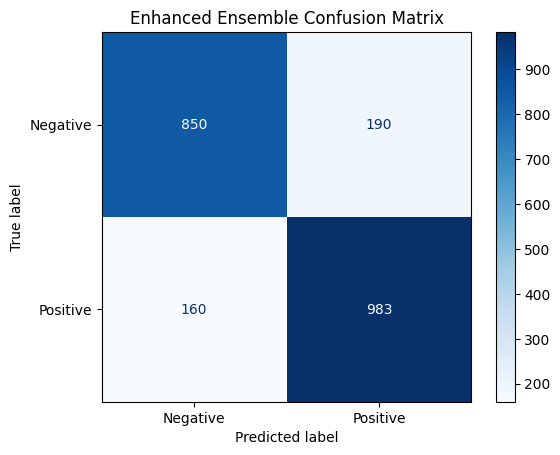

In [14]:
# Plot Ensemble Confusion Matrix (using weighted voting results)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_ensemble = confusion_matrix(val_labels, ensemble_preds)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=["Negative", "Positive"])
disp_ensemble.plot(cmap="Blues")
plt.title("Enhanced Ensemble Confusion Matrix")
plt.show()

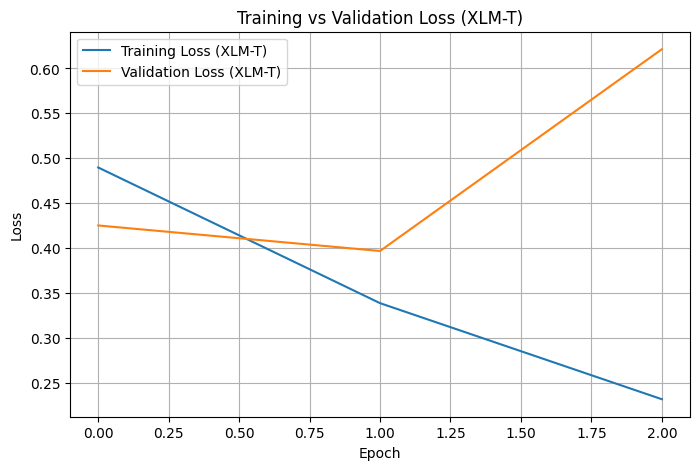

In [15]:
# Plot Training vs Validation Loss (using XLM-T logs as representative)
logs = xlmt_trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss (XLM-T)")
plt.plot(eval_loss, label="Validation Loss (XLM-T)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (XLM-T)")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Save Ensemble Predictions to CSV (including meta-classifier predictions)
ensemble_pred_df = pd.DataFrame({
    "text": val_texts,
    "true_label": val_labels,
    "ensemble_predicted_label": ensemble_preds,
    "meta_predicted_label": meta_preds  # from meta-classifier stacking
})
ensemble_pred_df.to_csv("ensemble_predictions.csv", index=False)
print("✅ Saved ensemble predictions to 'ensemble_predictions.csv'")

✅ Saved ensemble predictions to 'ensemble_predictions.csv'


In [17]:
# ----- Ensemble Prediction UI -----
from IPython.display import display
import ipywidgets as widgets

input_box_ensemble = widgets.Text(
    value='',
    placeholder='Type your Roman Urdu review here...',
    description='Ensemble:',
    layout=widgets.Layout(width='80%')
)
output_ensemble = widgets.Output()

def predict_sentiment_ensemble(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    xlmt_model.to(device)
    distil_model.to(device)

    def normalize_input(text):
        text = text.lower()
        text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        return " ".join([normalization_dict.get(w, w) for w in text.split()])

    cleaned = normalize_input(text)
    xlmt_inputs = xlmt_tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    distil_inputs = distil_tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    with torch.no_grad():
        xlmt_out = torch.nn.functional.softmax(xlmt_model(**xlmt_inputs).logits, dim=-1).cpu().numpy()[0]
        distil_out = torch.nn.functional.softmax(distil_model(**distil_inputs).logits, dim=-1).cpu().numpy()[0]

    combined = (0.7 * xlmt_out) + (0.3 * distil_out)
    label = int(np.argmax(combined))
    conf = float(np.max(combined))
    label_map = {0: "Negative", 1: "Positive"}
    return label_map[label], round(conf * 100, 2)

def on_button_click_ensemble(b):
    output_ensemble.clear_output()
    with output_ensemble:
        sentiment, confidence = predict_sentiment_ensemble(input_box_ensemble.value)
        print(f"🧠 Ensemble Predicted Sentiment: {sentiment}")
        print(f"📊 Confidence: {confidence}%")

button_ensemble = widgets.Button(description="Predict Ensemble", button_style='success')
button_ensemble.on_click(on_button_click_ensemble)
display(input_box_ensemble, button_ensemble, output_ensemble)

Text(value='', description='Ensemble:', layout=Layout(width='80%'), placeholder='Type your Roman Urdu review h…

Button(button_style='success', description='Predict Ensemble', style=ButtonStyle())

Output()